In [1]:
import os
os.chdir('..')
import pandas as pd
import numpy as np
from tqdm import tqdm
from algorithms.Model_LightGBM import LightGBM
from algorithms.Model_Generator import Generator
from warnings import filterwarnings
filterwarnings("ignore")
from preprocessing.preprocessing import preprocessing
from metrics.MAPE import MAPE

from utils import add_all_features

train = pd.read_csv("dataset/original/train.csv")
test = pd.read_csv("dataset/original/x_test.csv")
cluster=pd.read_csv("dataset/cluster.csv")

In [2]:
useTest = True
useScope = True
isEvaluation = False
useSampleWeights, weights_type = True, 2
save = False

if isEvaluation:
    useTest = False
    useScope = False

In [3]:
df = preprocessing(train, test, useTest=useTest)

df, categorical_f = add_all_features(df)
categorical_f = ['sku', 'pack', 'brand'] + categorical_f

df = df.sort_values('Date')

#   --------------- Model -----------------

drop_cols = ['scope', 'Date', 'real_target', 'pack', 'size (GM)', 'cluster','target'
#              'year','week_of_the_year','brand','month'
            ]
categorical_f = [x for x in categorical_f if x not in drop_cols]

CLUSTER = [1,2]      # Set CLUSTER = None if you want NOT to consider any cluster
NAME = 'lgb_no_cluster_1'

model = LightGBM()
model_gen = Generator(df, model,
                        categorical_features=categorical_f,
                        drop_columns=drop_cols,
                        isScope=useScope,
                        sample_weights_type=weights_type,
                        evaluation=isEvaluation,
                        useTest=useTest,
                        cluster=None,
                        name=NAME)

prediction = model_gen.run_generator(save)

model_gen.compute_MAPE()

6019it [00:00, 7829.42it/s]
6019it [00:00, 39232.12it/s]
100%|██████████| 43/43 [00:00<00:00, 804.45it/s]
25it [01:05,  2.63s/it]

Index(['Date', 'sku', 'target', 'real_target',
       'log_prediction_lgb_no_cluster_1', 'prediction_lgb_no_cluster_1'],
      dtype='object')
Standard MAPE = 8.745968729353827


## Random Forest using Cluster

In [35]:
from utils import dfs_gen
from sklearn.ensemble import RandomForestRegressor
tot_mape=0
date = [] 
sku = []
pred = []

for s in set(test.sku):
    current_sku = s
    clu1=(cluster[cluster.Sku==s].Label).values
    clu=cluster[cluster.Label==clu1[0]].Sku
    tr=pd.DataFrame()
    for i in clu:
        tr=tr.append(df[df.sku==i])
    df_sku=tr
    #print(len(df_sku[(df_sku.Date >= '2019-06-29')&(df_sku.sku==s)]['real_target']))
    #print(s,df_sku))
          
    #df_sku = df[df.sku == current_sku]
    test_dates = df_sku[df_sku.Date >= '2019-06-29']
    test_dates = test_dates.drop_duplicates('Date').Date
    generator = dfs_gen(df_sku, test_dates)
    lr = []
    for df_train, df_test in generator:
        #print(df_train,df_test)
        
        X = df_train.drop(drop_cols, axis=1).fillna(0)
        y = df_train.real_target.dropna()
        reg = RandomForestRegressor(100).fit(X, y)
        date.append(list(df_test.Date)[0])
        sku.append(s)
        #train_pred.append(float(reg.predict(df_train.drop(drop_cols, axis=1).fillna(0))[0]))
        pred.append(float(reg.predict(df_test[df_test.sku==s].drop(drop_cols, axis=1).fillna(0))[0]))
        lr.append(reg.predict(df_test[df_test.sku==s].drop(drop_cols, axis=1).fillna(0))[0])
    tmp_mape = MAPE(df_sku[(df_sku.Date >= '2019-06-29')&(df_sku.sku==s)]['real_target'].dropna(), lr[:24])
    tot_mape+=tmp_mape
    print(f"{s}: {tmp_mape}")

546: 12.396124809630955
1027: 9.998826774070785
1058: 18.426877910754413
549: 13.916113203239611
1065: 10.105162217180249
554: 10.567223776359501
1035: 9.787019769002086
686: 8.903778841911691
144: 17.311844641019373
688: 13.782050826629009
1206: 8.273538953340582
1051: 7.156280437650903


In [ ]:
preds_lr.to_csv('pred_RF_Clu.csv')

In [36]:
preds_rf_clu = pd.DataFrame()
preds_rf_clu['Date'] = date
preds_rf_clu['sku'] = sku
preds_rf_clu['pred_RF'] = pred
#preds_lr[preds_lr.sku==144]
#preds_lr['target']=test['sales w-1']
preds_rf_clu

,Date,sku,pred_RF
0,2019-06-29,546,68209.31
1,2019-07-06,546,62340.07
2,2019-07-13,546,78680.03
3,2019-07-20,546,153738.17
4,2019-07-27,546,128083.50
...,...,...,...
295,2019-11-16,1051,30997.54
296,2019-11-23,1051,42915.39
297,2019-11-30,1051,43154.57
298,2019-12-07,1051,24946.34


In [37]:

y_t=test[test.sku==546]['sales w-1']


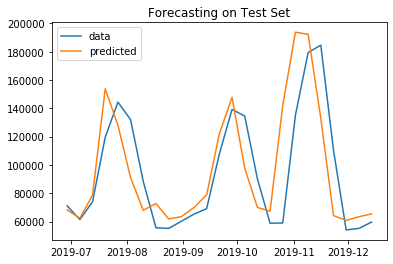

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

dictio={'target':np.asarray(y_t),'predicted':np.asarray(preds_rf_clu[preds_rf_clu.sku==546]['pred_RF'])}
df_result_forest_test = pd.DataFrame(dictio)

#df_result_forest_test


plt.plot(preds_lr[preds_rf_clu.sku==546].Date,df_result_forest_test.target,label='data')
plt.plot(preds_lr[preds_rf_clu.sku==546].Date,df_result_forest_test['predicted'],label='predicted')

plt.title("Forecasting on Test Set")
plt.legend();


MAPE sul test

In [43]:
from utils import dfs_gen
from sklearn.ensemble import RandomForestRegressor
tot_mape=0
date = [] 
sku = []
pred1 = []

for s in list(set(prediction.sku)):
    current_sku = s
    df_sku = df[df.sku == current_sku]
    test_dates = df_sku[df_sku.Date >= '2019-06-29']
    test_dates = test_dates.drop_duplicates('Date').Date
    generator = dfs_gen(df_sku, test_dates)
    lr1 = []
    for df_train, df_test in generator:
        X = df_train.drop(drop_cols, axis=1).fillna(0)
        y = df_train.real_target.dropna()
        reg = RandomForestRegressor(100).fit(X, y)
        date.append(list(df_test.Date)[0])
        sku.append(s)
        #train_pred.append(float(reg.predict(df_train.drop(drop_cols, axis=1).fillna(0))[0]))
        pred1.append(float(reg.predict(df_test[df_test.sku==s].drop(drop_cols, axis=1).fillna(0))[0]))
        lr1.append(reg.predict(df_test[df_test.sku==s].drop(drop_cols, axis=1).fillna(0))[0])
    tmp_mape = MAPE(df_sku[(df_sku.Date >= '2019-06-29')&(df_sku.sku==s)]['real_target'].dropna(), lr1[:24])
    tot_mape+=tmp_mape
    print(f"{s}: {tmp_mape}")

546: 20.957061416895144
1027: 17.98976532507385
1058: 14.567309480693705
549: 20.502972949115605
1065: 15.572470271457437
554: 14.2677861451864
1035: 13.60309071559413
686: 10.240863960206315
144: 16.61170853315287
688: 14.459060894033001
1206: 10.39775040556468
1051: 7.9104642210013285


In [46]:
preds_rf = pd.DataFrame()
preds_rf['Date'] = date
preds_rf['sku'] = sku
preds_rf['pred_RF'] = pred1
#preds_lr[preds_lr.sku==144]
#preds_lr['target']=test['sales w-1']
preds_rf

,Date,sku,pred_RF
0,2019-06-29,546,69374.43
1,2019-07-06,546,67701.40
2,2019-07-13,546,81976.38
3,2019-07-20,546,106013.83
4,2019-07-27,546,107143.61
...,...,...,...
295,2019-11-16,1051,30940.53
296,2019-11-23,1051,43366.69
297,2019-11-30,1051,43474.79
298,2019-12-07,1051,24923.38


In [16]:

preds_lr.to_csv('pred_RF_noClu.csv')

In [47]:
y_t=test[test.sku==546]['sales w-1']


In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

dictio={'target':np.asarray(y_t),'predicted':np.asarray(preds_rf[preds_rf.sku==546]['pred_RF'])}
df_result_forest_test = pd.DataFrame(dictio)

#df_result_forest_test

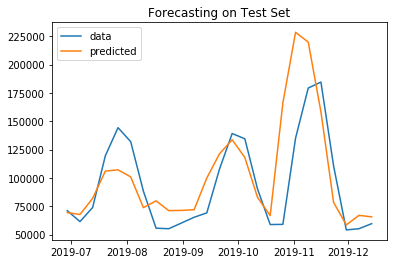

In [49]:

plt.plot(preds_rf[preds_rf.sku==546].Date,df_result_forest_test.target,label='data')
plt.plot(preds_rf[preds_rf.sku==546].Date,df_result_forest_test['predicted'],label='predicted')

plt.title("Forecasting on Test Set")
plt.legend();


## With cluster

In [53]:
df_ens_clu = pd.merge(prediction, preds_rf_clu, how='left')
df_ens_clu['pred_RF'] = df_ens_clu['pred_RF'].astype(float) 
df_ens_clu.head()

,Date,sku,target,real_target,log_prediction_lgb_no_cluster_1,prediction_lgb_no_cluster_1,pred_RF
0,2019-06-29,144,9.694555,16228.0,9.616715,15012.651166,17137.73
1,2019-06-29,546,11.025295,61407.0,11.138380,68759.161165,68209.31
2,2019-06-29,549,10.427565,33777.0,10.570172,38954.388658,43560.91
3,2019-06-29,554,11.717286,122673.0,11.809471,134519.367335,136185.70
4,2019-06-29,686,9.960718,21177.0,9.834768,18670.775315,19109.58


In [55]:
print('\033[1m'+ "Random Forest MAPE:" +'\033[0m' \
      + f"{MAPE(df_ens_clu.dropna().real_target, df_ens_clu.dropna().pred_RF)}")

Random Forest MAPE:11.71873684673243


## Without Cluster

In [56]:
df_ens = pd.merge(prediction, preds_rf, how='left')
df_ens['pred_RF'] = df_ens['pred_RF'].astype(float) 
df_ens.head()

,Date,sku,target,real_target,log_prediction_lgb_no_cluster_1,prediction_lgb_no_cluster_1,pred_RF
0,2019-06-29,144,9.694555,16228.0,9.616715,15012.651166,18999.40
1,2019-06-29,546,11.025295,61407.0,11.138380,68759.161165,69374.43
2,2019-06-29,549,10.427565,33777.0,10.570172,38954.388658,37048.83
3,2019-06-29,554,11.717286,122673.0,11.809471,134519.367335,136978.78
4,2019-06-29,686,9.960718,21177.0,9.834768,18670.775315,19284.47


In [57]:
print('\033[1m'+ "Random Forest MAPE:" +'\033[0m' \
      + f"{MAPE(df_ens.dropna().real_target, df_ens.dropna().pred_RF)}")

Random Forest MAPE:14.75669202649787
